In [2]:
import math

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style="darkgrid")
import matplotlib.pyplot as plt
import os

### Load & remove Data

In [4]:
def load_df_n_rmv_unnamed():
    data = pd.read_csv('./extract_seoul.csv')
    loc_df = pd.read_csv('./loc_df.csv')
    
    data = data.drop(['Unnamed: 0'],1)
    loc_df = loc_df.drop(['Unnamed: 0'], 1)
    
    data['Date'] = pd.to_datetime(data['Date'])
    
    return data, loc_df

In [5]:
data, loc_df = load_df_n_rmv_unnamed()

### GLOBAL VAR

In [6]:
GU_ENG_NAME = ''
BASE_PATH = './TimeSeries/'
MODEL_NAME = 'LSTM'

TRAIN_RATIO = 0.80
WINDOW_SIZE = 4

### Dict 관련 함수 선언

In [7]:
def create_dict(a, b):
    d = dict()
    #갯수 다르면
    if len(a)-len(b) != 0:
        for i in range(len(a)-len(b)):
            b.append(None)
    #갯수 같으면
    for j in range(len(a)):
        d[a[j]] = b[j]
    return d

In [8]:
def find_val_using_key(dic, key):
    if key in dic:
        return dic[key]
    else:
        print('404 not found')
        return dic['서울']

In [9]:
def find_key_using_val(dic, val):
    return [k for k, v in dic.items() if v == val][0]

### Loc code gen

In [10]:
def loc_code_dict_gen():
    loc_code = loc_df['구분']
    loc_code_en = loc_df['Classification']
    
    loc_code_dict = create_dict(loc_code, loc_code_en)
    
    return loc_code_dict

In [11]:
loc_code_dict = loc_code_dict_gen()

In [12]:
find_key_using_val(loc_code_dict, 'Total')

'전국'

In [13]:
find_val_using_key(loc_code_dict, '강남aaa')

404 not found


'Seoul'

### 원하는 구만 선택하기

In [14]:
def select_gu_data(df):
    gu_name = input()
    
    global GU_ENG_NAME
    search_name = find_val_using_key(loc_code_dict, gu_name)
    GU_ENG_NAME = search_name
    
    return df[['Date', search_name]]    

In [205]:
gu_data = select_gu_data(data)
print(GU_ENG_NAME)

관악구
Gwanak-gu


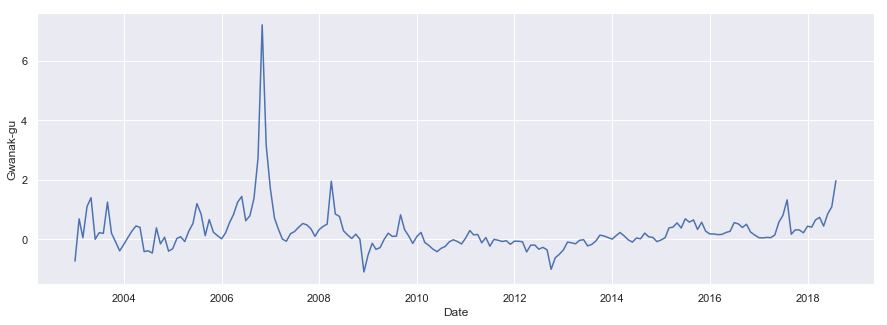

In [206]:
plt.figure(figsize = (15, 5))
ax = sns.lineplot(x="Date", y=GU_ENG_NAME, data=gu_data)

### Keras &  sklearn import

In [207]:
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.regularizers import L1L2

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import shuffle

In [208]:
gu_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188 entries, 0 to 187
Data columns (total 2 columns):
Date         188 non-null datetime64[ns]
Gwanak-gu    188 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.0 KB


### Select Date Range

In [209]:
def select_date_range(data):
    year = input('연도 입력: ')
    month = input('월 입력: ')
    
    date_str = year +'-'+ str(int(month)).zfill(2) + '-01'
    
    mask = pd.to_datetime(date_str)
    
    result = data.loc[:][data['Date'] >= mask]
    
    return result

In [210]:
result_dataset = select_date_range(gu_data)

연도 입력: 2010
월 입력: 1


In [211]:
result_dataset = result_dataset.set_index('Date')

### Normalize 0 ~ 1

In [238]:
def normalize_dataset(dataset):
    scaler = MinMaxScaler(feature_range = (0, 1))
    normed = scaler.fit_transform(dataset)
    
    return normed, scaler

In [239]:
normed_dataset, scaler = normalize_dataset(result_dataset)

### SKIP

In [ ]:
tmp = np.array(list(map(lambda x: x+0.0000001, normed_dataset)))

In [ ]:
tmp

### split tran & test

In [240]:
def train_test_divide(dataset, train_ratio = 0.8):
    train_size = int(len(dataset) * train_ratio)
    test_size = len(dataset) - train_size
    
    train, test = dataset[0:train_size], dataset[train_size:len(dataset)]
    print("Number of entries (training set, test set): " + str((len(train), len(test))))
    
    return train, test

In [241]:
train, test = train_test_divide(normed_dataset, TRAIN_RATIO)

Number of entries (training set, test set): (83, 21)


In [242]:
def create_dataset(dataset, window_size = 1):
    data_X, data_Y = [], []
    for i in range(len(dataset) - window_size - 1):
        a = dataset[i:(i + window_size), 0]
        data_X.append(a)
        data_Y.append(dataset[i + window_size, 0])
    return(np.array(data_X), np.array(data_Y))

In [243]:
train_X, train_Y = create_dataset(train, WINDOW_SIZE)
test_X, test_Y = create_dataset(test, WINDOW_SIZE)
whole_X, whole_Y = create_dataset(normed_dataset, WINDOW_SIZE)

print("Original training data shape: ", train_X.shape, train_Y.shape)
print("Original test data shape: ", test_X.shape, test_Y.shape)
print("Original whole data shape: ", whole_X.shape, whole_Y.shape)

Original training data shape:  (78, 4) (78,)
Original test data shape:  (16, 4) (16,)
Original whole data shape:  (99, 4) (99,)


In [244]:
def create_dataset_with_diff(x_last_val, y_val):
    diff = np.subtract(y_val, x_last_val)
    diff = np.reshape(diff, (diff.shape[0], 1))
    
    
    y_val = np.reshape(y_val, (y_val.shape[0], 1))
    
    result = np.concatenate((y_val, diff),axis=1)
    
    return result

In [245]:
train_y_n_dif = create_dataset_with_diff(train_X[:,3], train_Y)
test_y_n_dif = create_dataset_with_diff(test_X[:,3], test_Y)

In [220]:
test_y_n_dif

array([[ 0.3578087 , -0.00233113],
       [ 0.38776495,  0.02995625],
       [ 0.5341895 ,  0.14642455],
       [ 0.60982881,  0.07563931],
       [ 0.78407873,  0.17424992],
       [ 0.3963213 , -0.38775742],
       [ 0.44575291,  0.0494316 ],
       [ 0.44375982, -0.00199308],
       [ 0.41224646, -0.03151336],
       [ 0.48658106,  0.0743346 ],
       [ 0.47622145, -0.01035961],
       [ 0.55701151,  0.08079006],
       [ 0.5870038 ,  0.02999229],
       [ 0.48835732, -0.09864647],
       [ 0.6264669 ,  0.13810958],
       [ 0.70510776,  0.07864086]])

In [246]:
output_dim = len(train_y_n_dif[0])
output_dim

2

In [247]:
def reshape_dataset(train_x, test_x, whole_x):
    train_x = np.reshape(train_x, (train_x.shape[0], 1, train_x.shape[1]))
    test_x = np.reshape(test_x, (test_x.shape[0], 1, test_x.shape[1]))
    whole_x = np.reshape(whole_x ,(whole_x.shape[0], 1, whole_x.shape[1]))
    
    print("train_X re-shape: ", train_x.shape)
    print("test_X re-shape: ", test_x.shape)
    print("whole_X re-shape: ", whole_x.shape)
    return train_x, test_x, whole_x

In [248]:
train_X, test_X, whole_X = reshape_dataset(train_X, test_X, whole_X)

train_X re-shape:  (78, 1, 4)
test_X re-shape:  (16, 1, 4)
whole_X re-shape:  (99, 1, 4)


### define Checkpoint

In [249]:
MODEL_PATH = ''
if not os.path.exists(BASE_PATH):
    os.mkdir(BASE_PATH)

def create_checkpoint(model_name):
    global MODEL_PATH
    MODEL_PATH = os.path.join(BASE_PATH, model_name)
    
    
    MODEL_PATH = MODEL_PATH + "/" + GU_ENG_NAME
    print("Model_path : ", MODEL_PATH)
    
    if not os.path.exists(MODEL_PATH):
        os.mkdir(MODEL_PATH)
    
    return ModelCheckpoint(filepath=os.path.join(MODEL_PATH, 'val_loss-{val_loss:.6f}.hdf5'),
                           monitor='val_loss',
                           verbose=2,
                           save_best_only=True)

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=2, mode='min')

### define Model

In [250]:
def Model(train_X, train_Y, test_X, test_Y, window_size = 1):
    model = Sequential()
    model.add(LSTM (256,  activation = 'relu', return_sequences = False ,inner_activation = 'hard_sigmoid' , bias_regularizer=L1L2(l1=0.01, l2=0.01),  input_shape =(1, window_size)))
    model.add(Dense(output_dim))
    
#     adam = Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=1e-6, amsgrad=False)
    adam = Adam(lr=0.001, beta_1=0.89, beta_2=0.999, epsilon=1e-8, decay=1e-6, amsgrad=True)
    
    checkloss = create_checkpoint(MODEL_NAME)
    
    model.compile(loss = "mean_squared_error", optimizer = adam)

    model.summary()
    
    history = model.fit(train_X, train_Y, epochs = 2000 ,batch_size=4, validation_data=(test_X, test_Y),
                        shuffle=False,
                        callbacks=[checkloss, early_stopping])
    
    return model, history

In [251]:
model = Model(train_X, train_y_n_dif, test_X, test_y_n_dif, WINDOW_SIZE)

/Users/tax_k/anaconda3/envs/DL/lib/python3.6/site-packages/ipykernel/__main__.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(256, activation="relu", return_sequences=False, bias_regularizer=<keras.reg..., input_shape=(1, 4), recurrent_activation="hard_sigmoid")`
  app.launch_new_instance()


Model_path :  ./TimeSeries/LSTM/Gwanak-gu
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 256)               267264    
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 514       
Total params: 267,778
Trainable params: 267,778
Non-trainable params: 0
_________________________________________________________________
Train on 78 samples, validate on 16 samples
Epoch 1/2000
78/78 [==============================] - 2s 30ms/step - loss: 5.0974 - val_loss: 5.0504

Epoch 00001: val_loss improved from inf to 5.05037, saving model to ./TimeSeries/LSTM/Gwanak-gu/val_loss-5.050369.hdf5
Epoch 2/2000
78/78 [==============================] - 0s 2ms/step - loss: 4.9196 - val_loss: 4.8575

Epoch 00002: val_loss improved from 5.05037 to 4.85754, saving model to ./TimeSeries/LSTM/Gwanak-gu/val_loss-4.857536.hdf5
E


Epoch 00034: val_loss improved from 1.49573 to 1.42379, saving model to ./TimeSeries/LSTM/Gwanak-gu/val_loss-1.423787.hdf5
Epoch 35/2000
78/78 [==============================] - 0s 3ms/step - loss: 1.3790 - val_loss: 1.3539

Epoch 00035: val_loss improved from 1.42379 to 1.35385, saving model to ./TimeSeries/LSTM/Gwanak-gu/val_loss-1.353853.hdf5
Epoch 36/2000
78/78 [==============================] - 0s 3ms/step - loss: 1.3099 - val_loss: 1.2857

Epoch 00036: val_loss improved from 1.35385 to 1.28567, saving model to ./TimeSeries/LSTM/Gwanak-gu/val_loss-1.285666.hdf5
Epoch 37/2000
78/78 [==============================] - 0s 3ms/step - loss: 1.2426 - val_loss: 1.2193

Epoch 00037: val_loss improved from 1.28567 to 1.21929, saving model to ./TimeSeries/LSTM/Gwanak-gu/val_loss-1.219293.hdf5
Epoch 38/2000
78/78 [==============================] - 0s 2ms/step - loss: 1.1771 - val_loss: 1.1547

Epoch 00038: val_loss improved from 1.21929 to 1.15473, saving model to ./TimeSeries/LSTM/Gwanak-gu

78/78 [==============================] - 0s 2ms/step - loss: 0.0041 - val_loss: 0.0171

Epoch 00073: val_loss did not improve from 0.01675
Epoch 74/2000
78/78 [==============================] - 0s 2ms/step - loss: 0.0041 - val_loss: 0.0171

Epoch 00074: val_loss did not improve from 0.01675
Epoch 75/2000
78/78 [==============================] - 0s 2ms/step - loss: 0.0041 - val_loss: 0.0171

Epoch 00075: val_loss did not improve from 0.01675
Epoch 76/2000
78/78 [==============================] - 0s 3ms/step - loss: 0.0041 - val_loss: 0.0171

Epoch 00076: val_loss did not improve from 0.01675
Epoch 77/2000
78/78 [==============================] - 0s 2ms/step - loss: 0.0041 - val_loss: 0.0172

Epoch 00077: val_loss did not improve from 0.01675
Epoch 78/2000
78/78 [==============================] - 0s 1ms/step - loss: 0.0041 - val_loss: 0.0171

Epoch 00078: val_loss did not improve from 0.01675
Epoch 79/2000
78/78 [==============================] - 0s 1ms/step - loss: 0.0041 - val_loss: 0.

78/78 [==============================] - ETA: 0s - loss: 0.003 - 0s 2ms/step - loss: 0.0040 - val_loss: 0.0196

Epoch 00126: val_loss did not improve from 0.01675
Epoch 127/2000
78/78 [==============================] - 0s 2ms/step - loss: 0.0040 - val_loss: 0.0196

Epoch 00127: val_loss did not improve from 0.01675
Epoch 128/2000
78/78 [==============================] - 0s 2ms/step - loss: 0.0040 - val_loss: 0.0197

Epoch 00128: val_loss did not improve from 0.01675
Epoch 129/2000
78/78 [==============================] - 0s 2ms/step - loss: 0.0040 - val_loss: 0.0198

Epoch 00129: val_loss did not improve from 0.01675
Epoch 130/2000
78/78 [==============================] - 0s 2ms/step - loss: 0.0040 - val_loss: 0.0198

Epoch 00130: val_loss did not improve from 0.01675
Epoch 131/2000
78/78 [==============================] - 0s 2ms/step - loss: 0.0040 - val_loss: 0.0199

Epoch 00131: val_loss did not improve from 0.01675
Epoch 132/2000
78/78 [==============================] - 0s 2ms/step

In [256]:
def predict_and_score2(model, X, Y):
    pred = scaler.inverse_transform(model.predict(X))
    gt_val = scaler.inverse_transform(Y)
    
    return (pred, gt_val)

In [257]:
predict_and_score2(model[0], train_X, train_y_n_dif)

(array([[-0.17167185, -0.9592216 ],
        [-0.24710111, -0.93677425],
        [-0.34316722, -0.95818925],
        [-0.2885273 , -1.0059854 ],
        [-0.2229434 , -1.006612  ],
        [-0.08682556, -1.0077233 ],
        [-0.01154583, -1.0113946 ],
        [-0.05964732, -1.0045253 ],
        [-0.12329067, -0.98333883],
        [ 0.002339  , -1.0463797 ],
        [ 0.2529733 , -1.0460112 ],
        [ 0.18552527, -0.9865821 ],
        [ 0.13910522, -1.0356908 ],
        [-0.02775462, -0.9006266 ],
        [ 0.01759779, -1.0446211 ],
        [-0.11849546, -0.8990381 ],
        [-0.06266732, -1.057931  ],
        [ 0.00407828, -0.98980975],
        [-0.06705586, -1.0100505 ],
        [-0.04155639, -1.0119866 ],
        [-0.11631028, -0.9687122 ],
        [-0.07830474, -1.028038  ],
        [-0.04498279, -1.0023425 ],
        [-0.07277604, -1.0110704 ],
        [-0.29743868, -0.8683551 ],
        [-0.22911045, -1.0345712 ],
        [-0.14905874, -0.9858468 ],
        [-0.2755593 , -0.964

In [273]:
train_predict, train_orig = predict_and_score2(model[0], train_X, train_y_n_dif)
test_predict, test_orig = predict_and_score2(model[0], test_X, test_y_n_dif)
# whole_test,mae_whole, whole_predict, whole_orig = predict_and_score(model[0], whole_X, whole_Y)

In [274]:
def start_predict_n_plot(dataset, train_predict, test_predict):
    train_predict_plot = np.empty_like(dataset)
    train_predict_plot[:, :] = np.nan
    
    t_prd = np.array(train_predict[:,0])
    t_prd = np.reshape(t_prd, (t_prd.shape[0], 1))
    
    train_predict_plot[WINDOW_SIZE - 1:len(train_predict) + WINDOW_SIZE - 1, :] = t_prd

    test_predict_plot = np.empty_like(dataset)
    test_predict_plot[:, :] = np.nan
    
    test_prd = np.array(test_predict[:,0])
    test_prd = np.reshape(test_prd, (test_prd.shape[0], 1))
    
    test_predict_plot[len(test_predict) + (WINDOW_SIZE * 2) :len(dataset) - 2 , :] = t_prd
    
    print(test_predict_plot)
    
    title_label = GU_ENG_NAME + " Train / Test Predict"

    plt.figure(figsize = (15, 5))
    plt.plot(dataset, label = "True value")
    plt.plot(train_predict_plot, label = "Training set pred")
#     plt.plot(test_predict_plot, label = "Test set pred")
    plt.xlabel("Month")
    plt.ylabel("Price")
    plt.title(title_label)
    plt.legend()
    plt.show()

In [275]:
start_predict_n_plot(result_dataset, train_predict, test_predict)

[[        nan]
 [        nan]
 [        nan]
 [        nan]
 [        nan]
 [        nan]
 [        nan]
 [        nan]
 [        nan]
 [        nan]
 [        nan]
 [        nan]
 [        nan]
 [        nan]
 [        nan]
 [        nan]
 [        nan]
 [        nan]
 [        nan]
 [        nan]
 [        nan]
 [        nan]
 [        nan]
 [        nan]
 [-0.17167185]
 [-0.24710111]
 [-0.34316722]
 [-0.28852731]
 [-0.2229434 ]
 [-0.08682556]
 [-0.01154583]
 [-0.05964732]
 [-0.12329067]
 [ 0.002339  ]
 [ 0.25297329]
 [ 0.18552527]
 [ 0.13910522]
 [-0.02775462]
 [ 0.01759779]
 [-0.11849546]
 [-0.06266732]
 [ 0.00407828]
 [-0.06705586]
 [-0.04155639]
 [-0.11631028]
 [-0.07830474]
 [-0.04498279]
 [-0.07277604]
 [-0.29743868]
 [-0.22911045]
 [-0.14905874]
 [-0.27555931]
 [-0.25536621]
 [-0.28587785]
 [-0.68988812]
 [-0.52086246]
 [-0.37017053]
 [-0.27724159]
 [-0.07757232]
 [-0.04798042]
 [-0.14101753]
 [-0.05361523]
 [-0.0076156 ]
 [-0.15389344]
 [-0.16652463]
 [-0.05854213]
 [ 0.11307

ValueError: view limit minimum -36842.200000000004 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

In [73]:
def predict_and_score(model, X, Y):
    pred = scaler.inverse_transform(model.predict(X))
    # 0 ~ 1 inverse origin
    gt_val = scaler.inverse_transform([Y])
    
    print(len(gt_val[0]))
    print(len(pred[:, 0]))
    
    #RMSE.
    rmse = math.sqrt(mean_squared_error(gt_val[0], pred[:, 0]))
    
    #MAE
    mae = mean_absolute_error(gt_val[0], pred[:, 0])
    
    return(rmse, mae, pred, gt_val)

## Predict Future

In [ ]:
whole_predict[-window_size:]

In [ ]:
def predict_future(model, X, window_size):
    
    trans = X[-window_size:].T
    
    
    tmp_shape = np.reshape(trans, (trans.shape[0], 1, trans.shape[1]))
    pred = model.predict(tmp_shape)
    print("pred: ", pred)
    
    return pred

In [ ]:
future_pred = predict_future(model[0], whole_predict, WINDOW_SIZE)

In [ ]:
def make_future_data(model, predict, nb_future):
    for i in range(nb_future):
        print("len before: ", len(predict))
        future_pred = predict_future(model, predict, WINDOW_SIZE)
        predict = np.append(predict, future_pred, axis=0)
        
    return predict

In [ ]:
after_pred_data = make_future_data(model[0] ,whole_predict, 4)

In [ ]:
def whole_predict_n_plot(dataset, predict):
    
    true_value_plot = np.empty_like(dataset)
    print(true_value_plot.shape)
    print(whole_predict.shape)
    
    print('dataset_len : ', len(dataset))
    print('whole_predict_len : ', len(predict))
    
    
#     test_predict_plot[:, :] = np.nan
#     test_predict_plot[(window_size - 1): len(whole_predict) + (window_size - 1), :] = whole_predict

    whole_predict_plot = np.empty_like(predict)
    whole_predict_plot[:, :] = predict
    
    for i in range(WINDOW_SIZE - 1):
        whole_predict_plot = np.insert(whole_predict_plot, 0, 0)
    
    title_label = GU_ENG_NAME + " Train / Test Predict"
    
    plt.figure(figsize = (15, 5))
    plt.plot(scaler.inverse_transform(dataset), label = "True value")
    plt.plot(whole_predict_plot, label = "Test set pred")
    plt.xlabel("Month")
    plt.ylabel("Price")
    plt.title(title_label)
    plt.legend()
    plt.show()

In [ ]:
whole_predict_n_plot(dataset, after_pred_data)

### LSTM cross validation

In [ ]:
X, y = create_dataset(normed_dataset, window_size)

In [ ]:
X[:5]

In [ ]:
y[:5]

In [ ]:
tscv = TimeSeriesSplit(n_splits=10)

In [ ]:
for train_index, test_index in tscv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    print("\n")
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
    X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
    
    model = Model(X_train, y_train, X_test, y_test, window_size)
    
    best_weights = get_best_weights_path()
    model[0].load_weights(best_weights)
    
    plt.figure(figsize = (15, 5))
    plt.plot(model[1].history['loss'], label='train')
    plt.plot(model[1].history['val_loss'], label='test')
    plt.ylim([0.0, 0.05])
    plt.legend()
    plt.show()
    
    reshaped_X = np.reshape(X, (X.shape[0], 1, X.shape[1]))
    pred = scaler.inverse_transform(model[0].predict(reshaped_X))
    orig_data = scaler.inverse_transform([y])
    
    plt.figure(figsize = (15, 5))
    plt.plot(scaler.inverse_transform(dataset), label = "True value")
    plt.plot(pred[:, 0], label = "Test set pred")
    plt.xlabel("Month")
    plt.ylabel("Price")
    plt.title("Gangnam Train/test Predict")
    plt.legend()
    plt.show()
    
    whole_predict = pred[:, 0]
    for i in range(10):
        future_pred = predict_future(model[0], whole_predict, window_size)
        whole_predict.shape = (whole_predict.size//1, 1)
        whole_predict = np.append(whole_predict, future_pred, axis=0)
        
    plt.figure(figsize = (15, 5))
    plt.plot(scaler.inverse_transform(dataset), label = "True value")
    plt.plot(whole_predict, label = "Test set pred")
    plt.xlabel("Month")
    plt.ylabel("Price")
    plt.title("Gangnam Whole Predict")
    plt.legend()
    plt.show()

In [ ]:
for train_index, test_index in tscv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    print("\n")
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
    X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
    
    best_weights = get_best_weights_path()
    model[0].load_weights(best_weights)
    
    loaded_model = run_loaded_model(model[0], X_train, y_train, X_test, y_test, window_size)

In [ ]:
def predict_future(model, X, window_size):
    
    print('X shape: ', X.shape)
    
    trans = X[-window_size:].T
    print("trans: ", trans)
    print("type: ", type(trans))
    trans.shape = (trans.size//1, 1)
    print("trans: ", trans)
    print("trans shape: ", trans.shape)
    print("trans shape[0]: ", trans.shape[0])
    print("trans shape[1]1: ", trans.shape[1])
    
    tmp_shape = np.reshape(trans, (trans.shape[0], 1, trans.shape[1]))
    tmp_shape = tmp_shape.T
    print("tmp_shape: ", tmp_shape)
    pred = model.predict(tmp_shape)
    print("pred: ", pred)
    
#     print(pred[0])
    return pred

In [ ]:
whole_predict = pred[:, 0]

In [ ]:
for i in range(10):
    future_pred = predict_future(loaded_model[0], whole_predict, window_size)
    whole_predict.shape = (whole_predict.size//1, 1)
    whole_predict = np.append(whole_predict, future_pred, axis=0)

In [ ]:
test_predict_plot = np.empty_like(whole_predict)
print(len(test_predict_plot))
print(len(whole_predict))


print(test_predict_plot)
test_predict_plot[:, :] = np.nan
test_predict_plot[:, :] = whole_predict

# test_predict_plot = np.insert(test_predict_plot, 0, np.nan, axis=1)

test_predict_plot = np.insert(test_predict_plot, 0, 0)

In [ ]:
test_predict_plot = np.insert(test_predict_plot, 0, 0)

In [ ]:
test_predict_plot = np.delete(test_predict_plot, 0)

In [ ]:
print(len(test_predict_plot))

In [ ]:
plt.figure(figsize = (15, 5))
plt.plot(scaler.inverse_transform(dataset), label = "True value")
plt.plot(test_predict_plot, label = "Test set pred")
plt.xlabel("Month")
plt.ylabel("Price")
plt.title("Gangnam Train/test Predict")
plt.legend()
plt.show()

In [ ]:
# Reshape the input data into appropriate form for Keras.
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))
whole_X = np.reshape(whole_X, (whole_X.shape[0], 1, whole_X.shape[1]))

print("New training data shape:")
print(train_X.shape)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
 
T=25
history_val_loss=[]
 
for x in loaded_model[1].history['val_loss']:
    if x >= T:
        history_val_loss.append (T)
    else:
        history_val_loss.append( x )
        
plt.figure(figsize = (15, 15))
plt.plot(loaded_model[1].history['loss'])
plt.plot(history_val_loss)
plt.ylim([0.0, 0.05])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true) * 100)

### get Best weights model

In [ ]:
def ignore_hidden_file(fname):
    return not fname.startswith(".")

In [ ]:
def get_best_weights_path():
    file_list = os.listdir(MODEL_PATH)
    not_hidden_files = list(filter(ignore_hidden_file, file_list))
    result = MODEL_PATH + "/" + sorted(not_hidden_files)[0]
    print("Best weight path: ", result)
    
    return result

In [ ]:
best_weights = get_best_weights_path()

In [ ]:
def run_loaded_model(model, train_X, train_Y, X_test,y_test, window_size = 1):
#     adam = Adam(lr=0.00146, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=1e-6, amsgrad=False)
    adam = Adam(lr=0.001, beta_1=0.89, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=True)
    model.compile(loss = "mean_squared_error", 
                  optimizer = adam)
    model.summary()
    
    checkloss = create_checkpoint(MODEL_NAME)
    history = model.fit(train_X, train_Y, epochs = 1000 ,batch_size=4,  validation_data=(X_test, y_test),
                        shuffle=True,
                        callbacks=[checkloss, early_stopping])
    
    return model, history

In [ ]:
model[0].load_weights(best_weights)

loaded_model = run_loaded_model(model[0], train_X, train_Y, test_X, test_Y, WINDOW_SIZE)

In [ ]:
def mape(model, X, Y):
    pred = scaler.inverse_transform(model.predict(X))
    # 0 ~ 1 inverse origin
    orig_data = scaler.inverse_transform([Y])
    
    Y, pred = np.array(Y), np.array(pred)
    
    return np.mean(np.abs((Y - pred) / Y) * 100)

In [ ]:
rmse_train_score, train_predict, train_orig = predict_and_score(loaded_model[0], train_X, train_Y)
rmse_test_score, test_predict, test_orig = predict_and_score(loaded_model[0], test_X, test_Y)
whole_test_score, whole_predict, whole_orig = predict_and_score(loaded_model[0], whole_X, whole_Y)

print(whole_X[:5])
print(whole_Y[:5])
print('\n')
print("Training data score: %.2f RMSE" % rmse_train_score)
print("Test data score: %.2f RMSE" % rmse_test_score)
print("Whole data score: %.2f RMSE " % whole_test_score)

In [ ]:
mape(loaded_model[0], whole_X, whole_Y)

In [ ]:
mean_absolute_percentage_error(whole_orig[0], whole_predict[:, 0])

In [ ]:
whole_predict = np.append(whole_predict, future_pred, axis=0)

In [ ]:
for i in range(10):
    print("len before: ", len(whole_predict))
    future_pred = predict_future(model[0], whole_predict, window_size)
    
    print("future_pred")
    print(future_pred)
    whole_predict = np.append(whole_predict, future_pred, axis=0)

In [ ]:
whole_predict_n_plot(dataset, train_predict)